# Simple Sequence pipeline reading from multiple files

Goal
In this example, we will go through the creation of a pipeline using the SequenceReader operator. The pipeline will return the output of SequenceReader: a batch of sequences. These sequences are an arbitrary number of frames (images).

For more information on the SequenceReader parameters, please look at the documentation reference.

To make it clearer, let's look at how we can obtain these sequences and how to use them!

At first, we need to generate the images direcotry for SequenceReader.
use VidePipe to extract the images and saved as sequences folders. such as direcotry 0/1.png,0/2.png,,,1/,2/

In [1]:
from __future__ import print_function
from __future__ import division
import os
import numpy as np
import shutil
from nvidia.dali.pipeline import Pipeline
import nvidia.dali.ops as ops
import nvidia.dali.types as types

dali_extra_path = os.environ['DALI_EXTRA_PATH']
video_filename = dali_extra_path + "/db/optical_flow/sintel_trailer/sintel_trailer_short.mp4"
data_dir=dali_extra_path + "/db/sequence_reader/"
batch_size = 1
sequence_length = 10
initial_prefetch_size=16
n_iter=10



if os.path.exists(data_dir):
    shutil.rmtree(data_dir)
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

def save_images(image_batch, sequence):
    from PIL import Image
    for j in range(sequence):
       # print(image_batch.at(j))
        im = Image.fromarray(image_batch[j])
        im.save(str(j)  + '.png')
        

class VideoPipe(Pipeline):
    def __init__(self, batch_size, num_threads, device_id, data, shuffle):
        super(VideoPipe, self).__init__(batch_size, num_threads, device_id, seed=16)
        self.input = ops.VideoReader(device="gpu", filenames=data, sequence_length=sequence_length,
                                     shard_id=0, num_shards=1,
                                     random_shuffle=shuffle, initial_fill=initial_prefetch_size)


    def define_graph(self):
        output = self.input(name="Reader")
        return output
        
        
pipe = VideoPipe(batch_size=batch_size, num_threads=2, device_id=0, data=video_filename, shuffle=True)
pipe.build()
for i in range(n_iter):
    pipe_out = pipe.run()
    sequences_out = pipe_out[0].as_cpu().as_array()
    if not os.path.exists(data_dir+'/' + str(i)):
        os.makedirs(data_dir+'/' + str(i))
    os.chdir(data_dir+'/' + str(i))
    save_images(sequences_out[0],sequence_length)
     

Then, Create SequencePipeline
We will use matplotlib to display the frames we obtained

In [2]:
class SequencePipeline(Pipeline):
    def __init__(self, batch_size, num_threads, device_id):
        super(SequencePipeline, self).__init__(batch_size, num_threads, device_id, seed=16)
        self.input = ops.SequenceReader(file_root=data_dir, sequence_length=sequence_length)

    def define_graph(self):
        seq = self.input(name="Reader")

        return seq


%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
def show_sequence(sequence):
    columns = 5
    rows = (sequence_length + 1) // (columns)
    fig = plt.figure(figsize = (32,(16 // columns) * rows))
    gs = gridspec.GridSpec(rows, columns)
    for j in range(rows*columns):
        plt.subplot(gs[j])
        plt.axis("off")
        plt.imshow(sequence[j])

Build and run the pipe line, show all of the sequcenes from the batchs

Iteration 0
(1, 10, 720, 1280, 3)
Iteration 1
(1, 10, 720, 1280, 3)
Iteration 2
(1, 10, 720, 1280, 3)
Iteration 3
(1, 10, 720, 1280, 3)
Iteration 4
(1, 10, 720, 1280, 3)
Iteration 5
(1, 10, 720, 1280, 3)
Iteration 6
(1, 10, 720, 1280, 3)
Iteration 7
(1, 10, 720, 1280, 3)
Iteration 8
(1, 10, 720, 1280, 3)
Iteration 9
(1, 10, 720, 1280, 3)


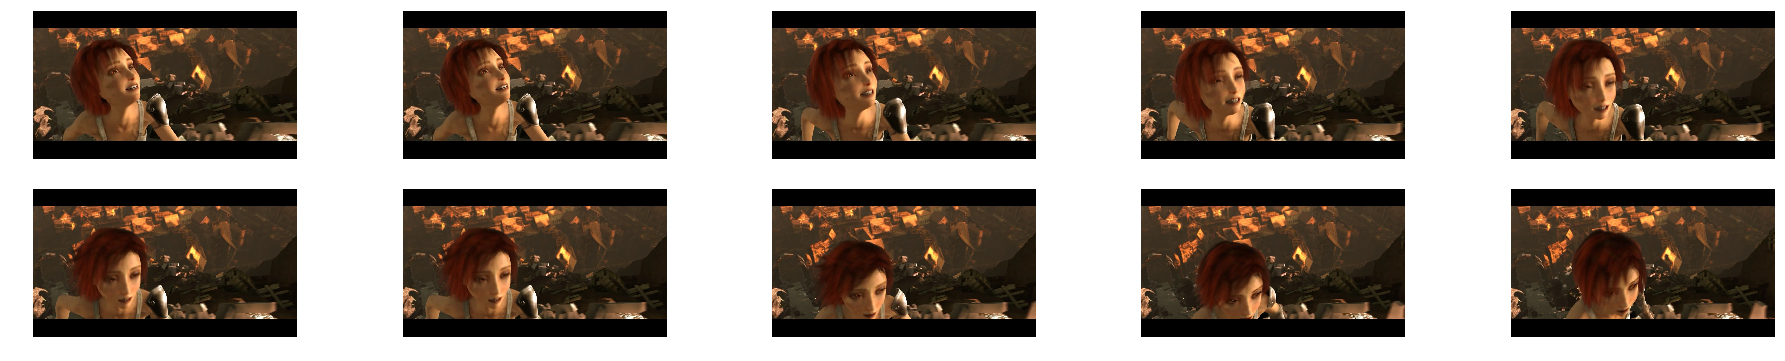

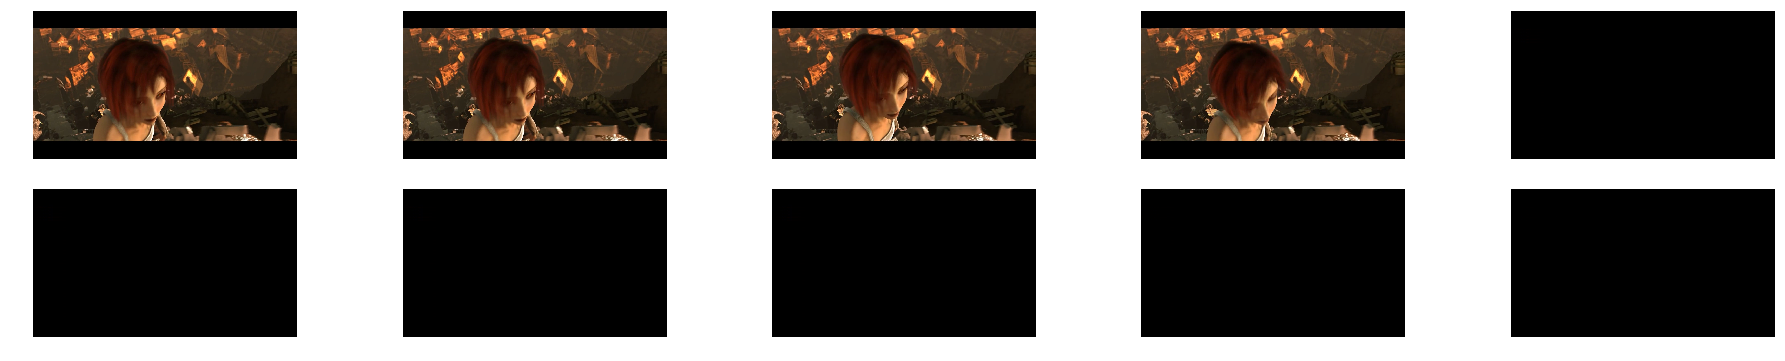

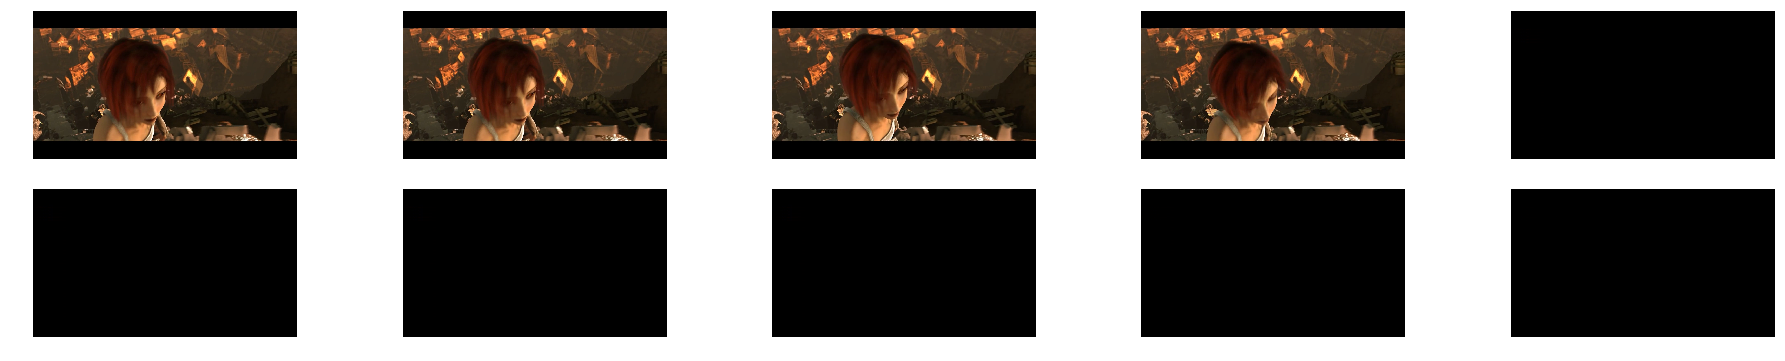

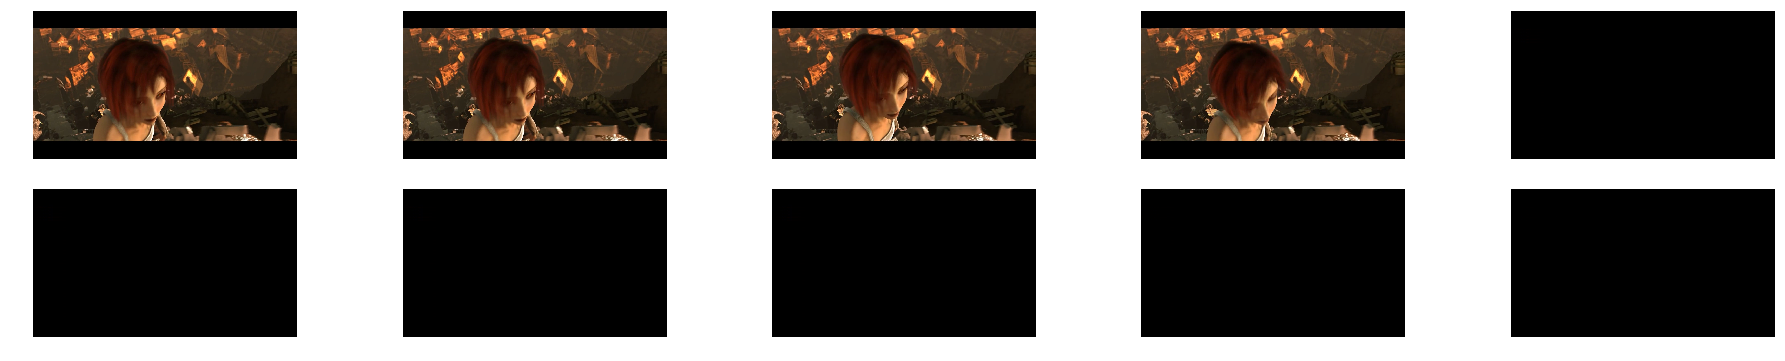

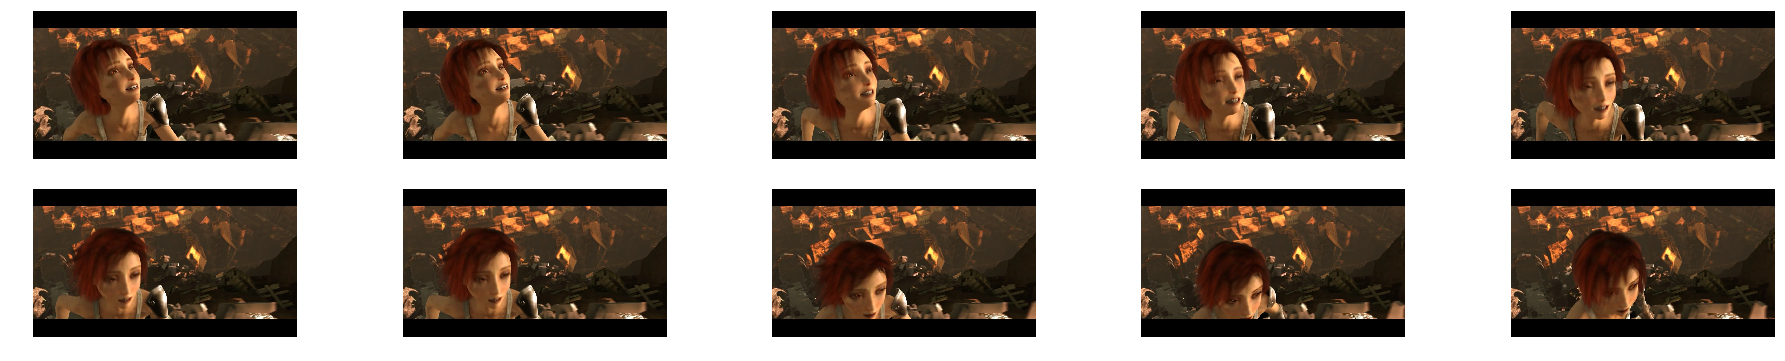

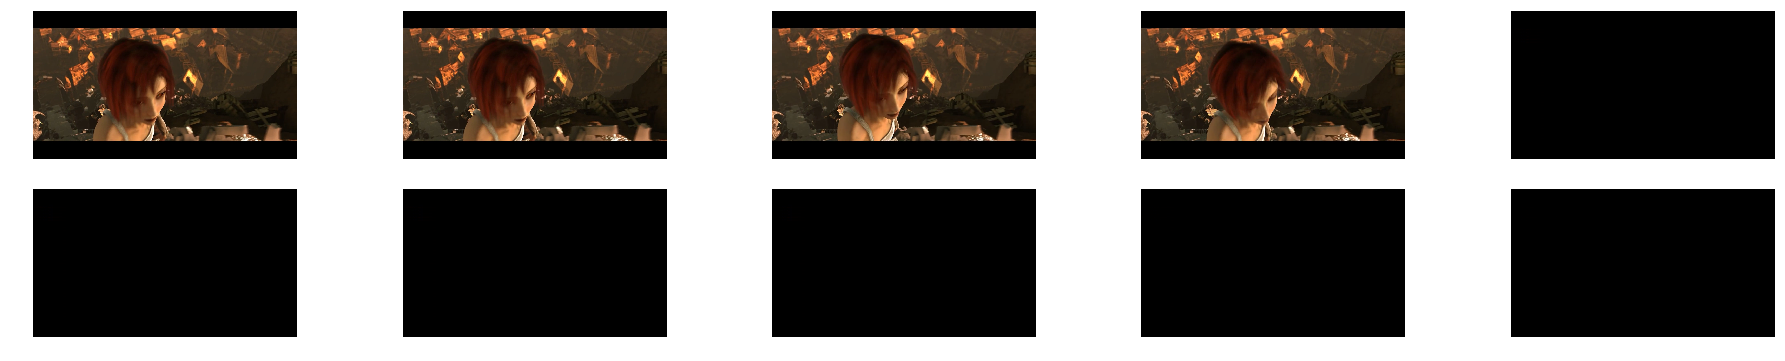

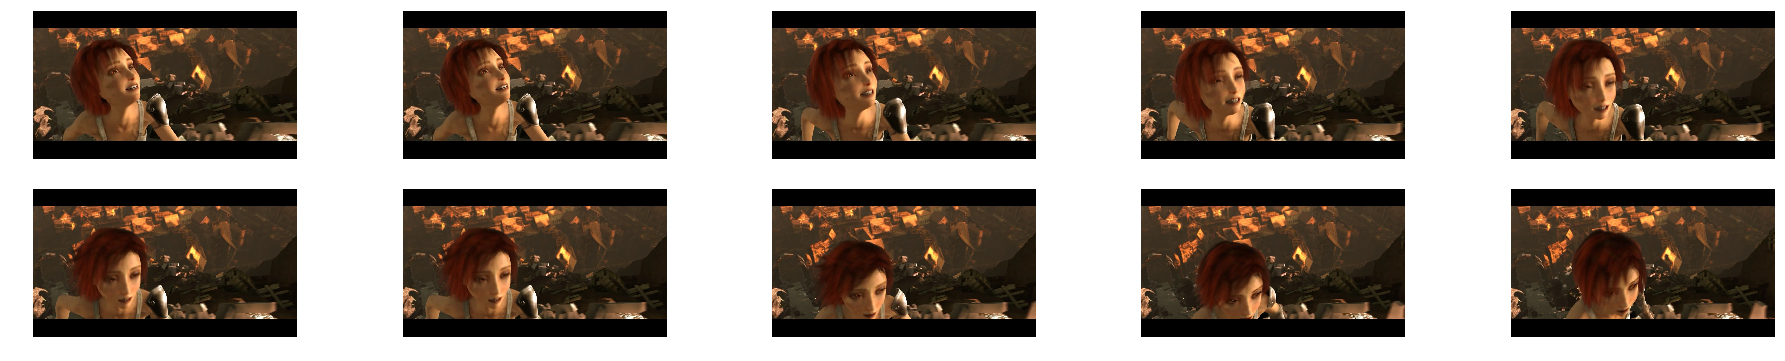

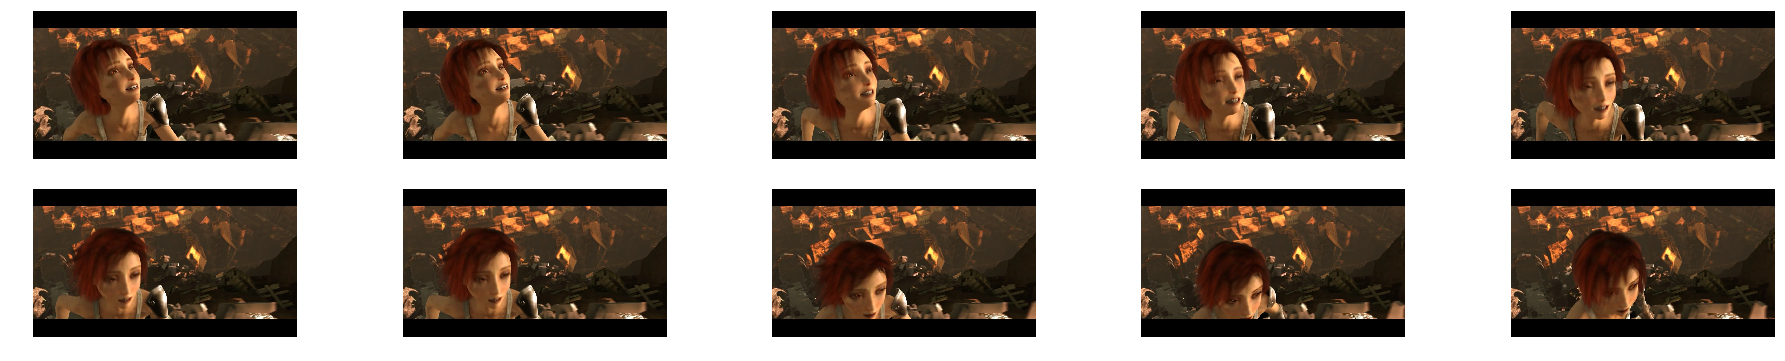

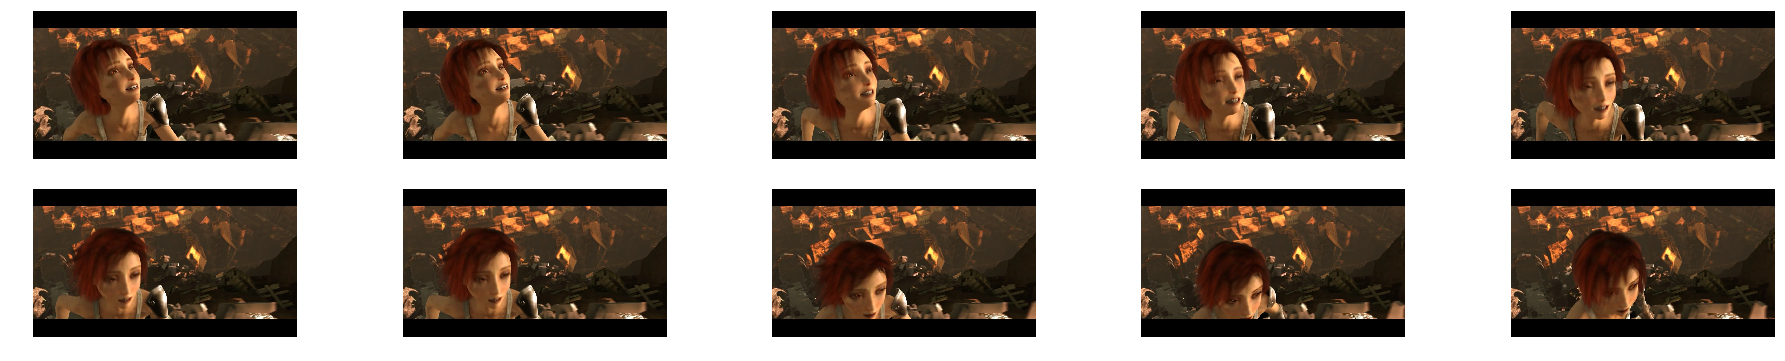

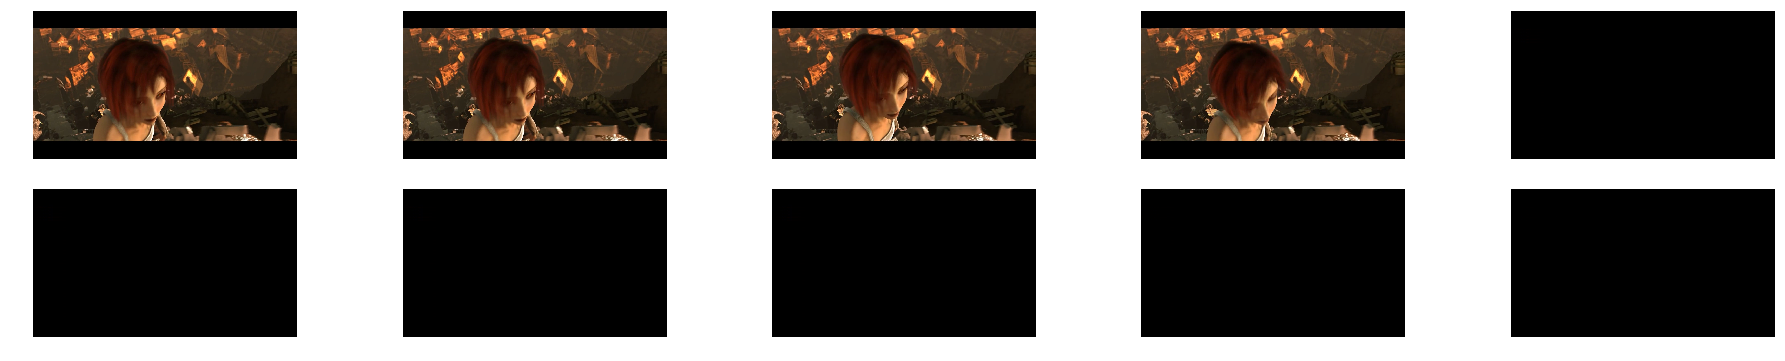

In [3]:
pipe = SequencePipeline(batch_size, 1, 0)
pipe.build()


for i in range(n_iter):
    print("Iteration " + str(i))
    pipe_out = pipe.run()
    sequences_out = pipe_out[0].as_array()
    print(sequences_out.shape)
    show_sequence(sequences_out[0])

    

        
        